In [1]:
# Authors: gracecaj@stud.ntnu.no, sbaarak@stud.ntnu.no & annakale@stud.ntnu.no
# Date: 09/03/2024

In [ ]:
    """_In this file we run our backcasting scenario the Storting's Carbon 
    Neutral Society_
    """

Import packages needed

In [2]:
#* Import the code needed
import os
from pathlib import Path
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import  norm, lognorm
from typing import List
import warnings

Set directory path

In [3]:
#* Define paths
directory_path = Path('../../')

Import datasets

In [4]:
# Import data from Excel files into pandas DataFrames.
pop = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Population' / 
    'regression_Population.xlsx',
    index_col=0)

PpD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'PpD' / 
    'regression_PpD.xlsx',
    index_col=0)

UFApD = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'UFApD' / 
    'UFApD_new.xlsx',
    index_col=0)

TS_cj = pd.read_excel(
    directory_path / 'data' / 'cleaned_and_combined_data' / 
    'Type_Split' / 'type_split_clean.xlsx',
    sheet_name='Sheet4', index_col=0)

lifetime = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' 
    / 'lifetime_regression.xlsx',
    index_col=0)

lifetime_standard_deviation = pd.read_excel(
    directory_path / 'data' / 'regression_data' / 'Dwelling_Lifetime' 
    / 'lifetime_regression.xlsx',
    index_col=0)

# Energy intensity
EI_SFH = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='SFH_Energy', index_col=0)

EI_TH = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='TH_Energy', index_col=0)
    
EI_AB = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='AB_Energy', index_col=0)

#Carbon intensity
CI_SFH = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='SFH_Carbon', index_col=0)

CI_TH = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='TH_Carbon', index_col=0)
    
CI_AB = pd.read_excel(
    directory_path / 'data' / 'modified_parameters_scenario_2' / 
    'Energy_and_Carbon_TEK_and_Renovation.xlsx',
    sheet_name='AB_Carbon', index_col=0)

Seperate out the lifetime and standard deviation datasets

In [5]:
#lifetime = lifetime.drop('std_dev', axis=1)
lifetime_standard_deviation = lifetime_standard_deviation.drop(
    'Avg_lifetime', axis=1)

lifetime = lifetime.loc[:, 'Avg_lifetime'].to_numpy()
lifetime

lifetime_standard_deviation = lifetime_standard_deviation.loc[
    :, 'std_dev'].to_numpy()

Import DSM module

In [6]:
# Getting the name of the directory where the this file is present
current = os.path.dirname(os.path.realpath('this'))
 
# Getting the parent directory name where the current directory is present
parent = os.path.dirname(current)
# Make the UA path
module_path = parent + '/modules'
# Append path to options to import from
sys.path.append(module_path)

# Import DSM and renovation model
from dynamic_stock_model import DynamicStockModel
import renovation_state_modeling_scenario as r_s_m
from importlib import reload
reload(r_s_m)
from renovation_state_modeling_scenario import get_renovation_cycles
from renovation_state_modeling_scenario import RenovationStock
from renovation_state_modeling_scenario import EnergyIntensity

Calculate stock from pop/PpD

In [7]:
stock_t = np.divide(pop.drop_duplicates(),PpD)

C:\Users\Solveig\AppData\Local\Temp\ipykernel_17812\4106792660.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  stock_t = np.divide(pop.drop_duplicates(),PpD)


Define a function that does the stock driven modeling

In [8]:
def calculate_inflow_by_type(inflow_t):
    SFH_inflow = pd.DataFrame()
    TH_inflow = pd.DataFrame()
    AB_inflow = pd.DataFrame()
    for year in inflow_t.columns:
        if int(year) <= 1900:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        'before 1900','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        'before 1900','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        'before 1900','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        if int(year) >= 1901 and int(year) <= 1955:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1901-1955','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1901-1955','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1901-1955','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1956 and int(year) <= 1970:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1956 - 1970','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1956 - 1970','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1956 - 1970','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1971 and int(year) <= 1980:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1971 - 1980','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1971 - 1980','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1971 - 1980','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1981 and int(year) <= 1990:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1981 - 1990','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1981 - 1990','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1981 - 1990','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 1991 and int(year) <= 2000:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '1991 - 2000','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1991 - 2000','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['1991 - 2000','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2001 and int(year) <= 2010:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '2001 - 2010','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2001 - 2010','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc['2001 - 2010','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
        elif int(year) >= 2011:
            iteration_SFH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '2011 and after','% SFH']
                    )
                )
            SFH_inflow = pd.concat([SFH_inflow, iteration_SFH], axis=1)
            iteration_TH = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '2011 and after','% TH']
                    )
                )
            TH_inflow = pd.concat([TH_inflow, iteration_TH], axis=1)
            iteration_AB = pd.DataFrame(
                np.multiply(
                    inflow_t.loc[:,year],TS_cj.loc[
                        '2011 and after','% AB']
                    )
                )
            AB_inflow = pd.concat([AB_inflow, iteration_AB], axis=1)
    return SFH_inflow, TH_inflow, AB_inflow

In [9]:
def stock_driven_model(stock):
    dwellings_stock_driven = DynamicStockModel(t=np.arange(1600, 2051),
                         s=stock['Pop'].to_numpy(),
                         lt={'Type': 'Normal', 
                             'Mean': lifetime,
                             'StdDev': lifetime_standard_deviation 
                             }
                        )
 
 # Compute the stock-driven model with negative inflow correction   
    dwellings_stock_driven.compute_stock_driven_model(
        NegativeInflowCorrect = True)

 # Make a dataframe with year 1600 to 2050   
    inflow_t = pd.DataFrame(dwellings_stock_driven.i, 
                            index=np.arange(1600,2051))

 # Calculate inflow by dwelling type with desired shape   
    inflow_t_SFH, inflow_t_TH, inflow_t_AB = calculate_inflow_by_type(
        inflow_t.T)
    inflow_t_SFH = inflow_t_SFH.T
    inflow_t_TH = inflow_t_TH.T
    inflow_t_AB = inflow_t_AB.T
 # Return the calculated inflow DataFrames for each dwelling type   
    return inflow_t_SFH, inflow_t_TH, inflow_t_AB

Run the stock driven model

In [10]:
i_SFH, i_TH, i_AB = stock_driven_model(stock_t)

Define a function that does the inflow driven modeling

In [11]:
def inflow_driven_model(inflow):
    dwellings_inflow_driven = DynamicStockModel(t=np.arange(1600, 2051),
                    i=inflow[0],
                    lt={'Type': 'Normal', 
                        'Mean': lifetime,
                        'StdDev': lifetime_standard_deviation 
                        }
                    )
    dwellings_inflow_driven.compute_s_c_inflow_driven()

    dwellings_inflow_driven.compute_stock_total()

    dwellings_inflow_driven.compute_o_c_from_s_c()

    return dwellings_inflow_driven.s_c, dwellings_inflow_driven.s, \
        dwellings_inflow_driven.o_c

Run the inflow driven model

In [12]:
s_c_SFH, s_SFH, o_SFH = inflow_driven_model(i_SFH)
s_c_TH, s_TH, o_TH = inflow_driven_model(i_TH)
s_c_AB, s_AB, o_AB = inflow_driven_model(i_AB)

In [13]:
i_SFH.rename(columns={0:'SFH'}, inplace=True)
i_TH.rename(columns={0:'TH'}, inplace=True)
i_AB.rename(columns={0:'AB'}, inplace=True)

Make s_c arrays into dataframes for easier use

In [14]:
#Stock SFH
s_SFH_df = pd.DataFrame(s_SFH)
s_SFH_df = s_SFH_df.set_index(UFApD.index)
s_SFH_df.columns = ['SFH']

#Stock TH
s_TH_df = pd.DataFrame(s_TH)
s_TH_df = s_TH_df.set_index(UFApD.index)
s_TH_df.columns = ['TH']

#Stock AB
s_AB_df = pd.DataFrame(s_AB)
s_AB_df = s_AB_df.set_index(UFApD.index)
s_AB_df.columns = ['AB']

#Stock SFH 1600 to 2050
s_c_SFH_df = pd.DataFrame(s_c_SFH)
s_c_SFH_df = s_c_SFH_df.set_index(UFApD.index)
s_c_SFH_df.columns = np.arange(1600, 2051)

#Stock TH 1600 to 2050
s_c_TH_df = pd.DataFrame(s_c_TH)
s_c_TH_df = s_c_TH_df.set_index(UFApD.index)
s_c_TH_df.columns = np.arange(1600, 2051)

#Stock AB 1600 to 2050
s_c_AB_df = pd.DataFrame(s_c_AB)
s_c_AB_df = s_c_AB_df.set_index(UFApD.index)
s_c_AB_df.columns = np.arange(1600, 2051)

#Inflow SFH
i_SFH_df = pd.DataFrame(i_SFH)
i_SFH_df = i_SFH_df.set_index(UFApD.index)

#Outflow SFH 1600 to 2050
o_SFH_df = pd.DataFrame(o_SFH)
o_SFH_df = o_SFH_df.set_index(UFApD.index)
o_SFH_df.columns = np.arange(1600, 2051)

#Inflow TH
i_TH_df = pd.DataFrame(i_TH)
i_TH_df = i_TH_df.set_index(UFApD.index)

#Outflow TH 1600 to 2050
o_TH_df = pd.DataFrame(o_TH)
o_TH_df = o_TH_df.set_index(UFApD.index)
o_TH_df.columns = np.arange(1600, 2051)

#Inflow AB
i_AB_df = pd.DataFrame(i_AB)
i_AB_df = i_AB_df.set_index(UFApD.index)

#Outflow AB 1600 to 2050
o_AB_df = pd.DataFrame(o_AB)
o_AB_df = o_AB_df.set_index(UFApD.index)
o_AB_df.columns = np.arange(1600, 2051)

Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [15]:
SFH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_SFH_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_SFH_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_SFH_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_SFH_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_SFH_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_SFH_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_SFH_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

TH_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_TH_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_TH_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_TH_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_TH_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_TH_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_TH_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_TH_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

AB_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_c_AB_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_c_AB_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_c_AB_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_c_AB_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_c_AB_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_c_AB_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_c_AB_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

Calculate total stock (s_total), total stock by cohort (s_c_total)

Calculate stock_changes by inflow - outflow for each type and aggregated

Calculate total inflows and outflows

In [16]:
# Total stock
s_total = s_SFH_df + s_TH_df + s_AB_df

# Total stock by cohort
total_stock_by_tabula_cohort = (
    SFH_stock_by_tabula_cohort
    + TH_stock_by_tabula_cohort
    + AB_stock_by_tabula_cohort
)

# Stock changes for each type
# Inflow minus outflow
stock_change_SFH = i_SFH_df.values - pd.DataFrame(o_SFH_df.sum(axis=1))
stock_change_SFH = pd.DataFrame(stock_change_SFH, 
                                index=np.arange(1600,2051))

stock_change_TH = i_TH_df.values - pd.DataFrame(o_TH_df.sum(axis=1))
stock_change_TH = pd.DataFrame(stock_change_TH, 
                               index=np.arange(1600,2051))

stock_change_AB = i_AB_df.values - pd.DataFrame(o_AB_df.sum(axis=1))
stock_change_AB = pd.DataFrame(stock_change_AB, 
                               index=np.arange(1600,2051))

# Total stock change
stock_change_total = (
    stock_change_SFH +
    stock_change_TH +
    stock_change_AB
)

# Total inflow and stored as a dataframe
i_total = i_SFH_df.values + i_TH_df.values + i_AB_df.values
i_total = pd.DataFrame(i_total, index=np.arange(1600,2051))

# Total outflow
o_total = o_SFH_df + o_TH_df + o_AB_df

Convert number of dwellings into floor area by DSM cohort

In [17]:
s_UFA_c_SFH = s_c_SFH_df @ np.diag(UFApD['UFApD SFH'])
s_UFA_c_SFH = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH.columns = np.arange(1600, 2051)

s_UFA_c_TH = s_c_TH_df @ np.diag(UFApD['UFApD TH'])
s_UFA_c_TH = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH.columns = np.arange(1600, 2051)

s_UFA_c_AB = s_c_AB_df @ np.diag(UFApD['UFApD AB'])
s_UFA_c_AB = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB.columns = np.arange(1600, 2051)

i_SFH_UFA = i_SFH_df.mul(UFApD['UFApD SFH'].values, axis=0)
i_SFH_UFA = pd.DataFrame(i_SFH_UFA)

o_SFH_UFA = o_SFH_df @ np.diag(UFApD['UFApD SFH'])
o_SFH_UFA = pd.DataFrame(o_SFH_UFA)
o_SFH_UFA.columns = np.arange(1600, 2051)

i_TH_UFA = i_TH_df.mul(UFApD['UFApD TH'].values, axis=0)
i_TH_UFA = pd.DataFrame(i_TH_UFA)

o_TH_UFA = o_TH_df @ np.diag(UFApD['UFApD TH'])
o_TH_UFA = pd.DataFrame(o_TH_UFA)
o_TH_UFA.columns = np.arange(1600, 2051)

i_AB_UFA = i_AB_df.mul(UFApD['UFApD AB'].values, axis=0)
i_AB_UFA = pd.DataFrame(i_AB_UFA)

o_AB_UFA = o_AB_df @ np.diag(UFApD['UFApD AB'])
o_AB_UFA = pd.DataFrame(o_AB_UFA)
o_AB_UFA.columns = np.arange(1600, 2051)

Make s_c_UFA arrays into dataframes for easier use

In [18]:
# To check how the dataframes looks for UFA of the types
s_UFA_c_SFH_df = pd.DataFrame(s_UFA_c_SFH)
s_UFA_c_SFH_df = s_UFA_c_SFH_df.set_index(UFApD.index)
s_UFA_c_SFH_df.columns = np.arange(1600, 2051)
s_UFA_c_SFH_df

s_UFA_c_TH_df = pd.DataFrame(s_UFA_c_TH)
s_UFA_c_TH_df = s_UFA_c_TH_df.set_index(UFApD.index)
s_UFA_c_TH_df.columns = np.arange(1600, 2051)
s_UFA_c_TH_df

s_UFA_c_AB_df = pd.DataFrame(s_UFA_c_AB)
s_UFA_c_AB_df = s_UFA_c_AB_df.set_index(UFApD.index)
s_UFA_c_AB_df.columns = np.arange(1600, 2051)
s_UFA_c_AB_df

,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
Year,,,,,,,,,,,,,,,,,,,,,
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270719e+06,1.277599e+06,1.284684e+06,1.291977e+06,1.299486e+06,1.307213e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270718e+06,1.277599e+06,1.284683e+06,1.291977e+06,1.299486e+06,1.307213e+06,1.315163e+06,0.000000e+00,0.000000e+00,0.000000e+00
2048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.270718e+06,1.277598e+06,1.284683e+06,1.291977e+06,1.299486e+06,1.307213e+06,1.315163e+06,1.323338e+06,0.000000e+00,0.000000e+00


Aggregate s_c dataframes into the cohorts from tabula for each type for plotting

In [19]:
SFH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_SFH_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_SFH_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

TH_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_TH_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_TH_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

AB_UFA_stock_by_tabula_cohort = pd.DataFrame(
    data={'pre-1955': pd.DataFrame(s_UFA_c_AB_df).loc[
        :,'1600':'1955'].sum(axis=1), 
          '1956-1970': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'1956':'1970'].sum(axis=1), 
          '1971-1980': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'1971':'1980'].sum(axis=1), 
          '1981-1990': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'1981':'1990'].sum(axis=1), 
          '1991-2000': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'1991':'2000'].sum(axis=1), 
          '2001-2010': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'2001':'2010'].sum(axis=1), 
          'post-2010': pd.DataFrame(s_UFA_c_AB_df).loc[
              :,'2011':'2050'].sum(axis=1)}
          )

Calculate total stock of UFA (s_UFA_total), total stock of UFA by cohort (total_stock_by_tabula_cohort)

Calculate stock_changes of UFA by inflow - outflow for each type and aggregated

Calculate total inflows and outflows of UFA

In [20]:
s_UFA_total = s_UFA_c_SFH.sum(axis=1) + s_UFA_c_TH.sum(
    axis=1) + s_UFA_c_AB.sum(axis=1)

total_stock_by_tabula_cohort = (
    SFH_stock_by_tabula_cohort
    + TH_stock_by_tabula_cohort
    + AB_stock_by_tabula_cohort
)

stock_change_SFH_UFA = i_SFH_UFA.values - pd.DataFrame(
    o_SFH_UFA.sum(axis=1))
stock_change_SFH_UFA = pd.DataFrame(
    stock_change_SFH_UFA, index=np.arange(1600,2051))

stock_change_TH_UFA = i_TH_UFA.values - pd.DataFrame(
    o_TH_UFA.sum(axis=1))
stock_change_TH_UFA = pd.DataFrame(
    stock_change_TH_UFA, index=np.arange(1600,2051))

stock_change_AB_UFA = i_AB_UFA.values - pd.DataFrame(
    o_AB_UFA.sum(axis=1))
stock_change_AB_UFA = pd.DataFrame(
    stock_change_AB_UFA, index=np.arange(1600,2051))

stock_change_total_UFA = (
    stock_change_SFH_UFA
    + stock_change_TH_UFA
    + stock_change_AB_UFA
)

i_total_UFA = i_SFH_UFA.values + i_TH_UFA.values + i_AB_UFA.values
i_total_UFA = pd.DataFrame(i_total_UFA, index=np.arange(1600,2051))

o_total_UFA = o_SFH_UFA + o_TH_UFA + o_AB_UFA

Do renovation modeling AFTER conversion to UFA

Start with setting up the AVERAGE renovation cycle

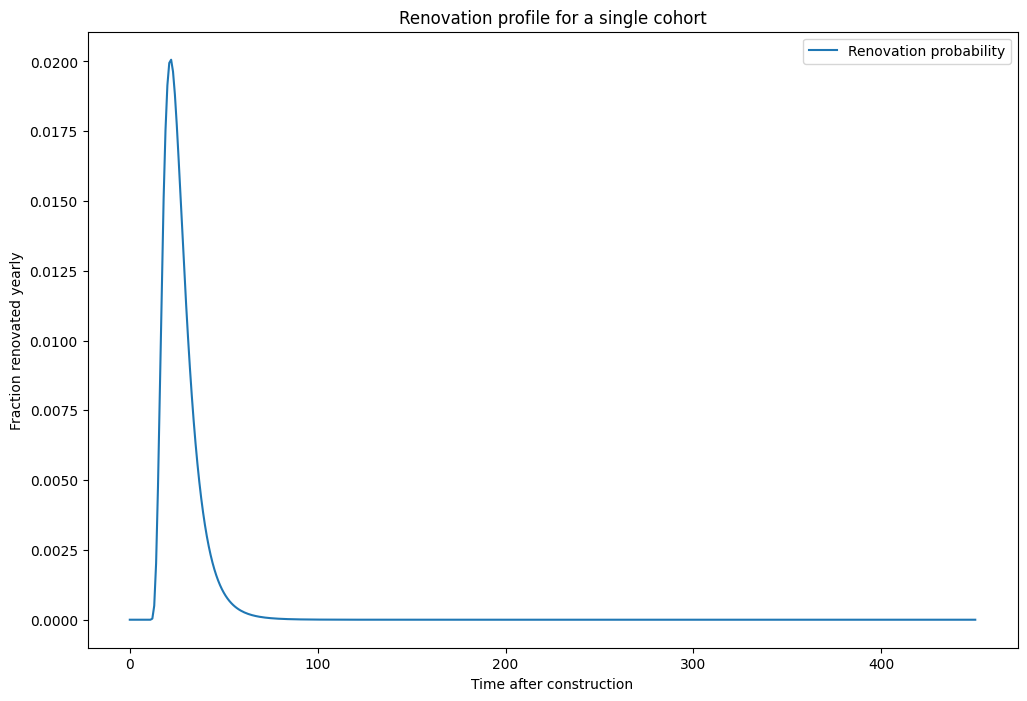

the actual mean of the outflow time in the first renovation cycles is at 9.0 years.


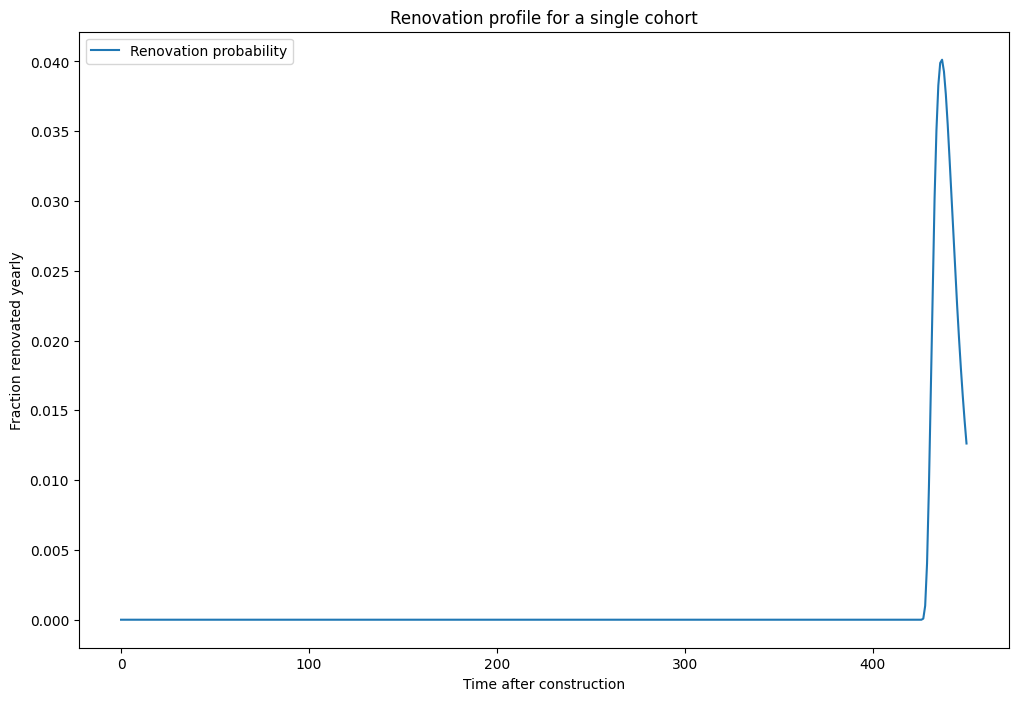

the actual mean of the outflow time in the first renovation cycles is at 250.6 years.


In [21]:
# Define years before and after 2025, when policy applies
time_interval_pre_policy = [0, 450]
time_interval_post_policy = [0, 450]

# Renovation every 20 year as average
no_cycles = 1
ren_mean_avg_pre_policy = 20
ren_mean_avg_post_policy = 20
ren_rel_std = 0.25

#Set up renovation cycles
renovation_cycle_avg_pre_policy = get_renovation_cycles(
    1/3,time_interval_pre_policy, no_cycles, 
    ren_mean_cycle=ren_mean_avg_pre_policy, 
    ren_rel_deviation = ren_rel_std, 
    distribution='lognorm', show = True)
renovation_cycle_avg_post_policy = get_renovation_cycles(
    2/3,time_interval_post_policy, no_cycles, 
    ren_mean_cycle=ren_mean_avg_post_policy, 
    ren_rel_deviation = ren_rel_std, loc=415, 
    distribution='lognorm', show = True)

# Define what renovation cycles before policy
renovation_cycle_avg_pre_policy = np.delete(
    renovation_cycle_avg_pre_policy, 
    [416,417,418,419,420,421,422,423,
     424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,
     440,441,442,443,444,445,446,447,448,449,450])

# Define what renovation cycles after policy
renovation_cycle_avg_post_policy = np.delete(
    renovation_cycle_avg_pre_policy, 
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
     25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,
     47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,
     69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,
     91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,
     110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,
     126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,
     142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,
     158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,
     174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,
     190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,
     206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,
     222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,
     238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,
     254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,
     270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,
     286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,
     302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,
     318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,
     334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,
     350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,
     366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,
     382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,
     398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,
     414,415])

# Plot renovation cycle
renovation_cycle_avg = np.concatenate(
    (renovation_cycle_avg_pre_policy, 
     renovation_cycle_avg_post_policy), axis=0)

Setting up the AVERAGE renovation cycle

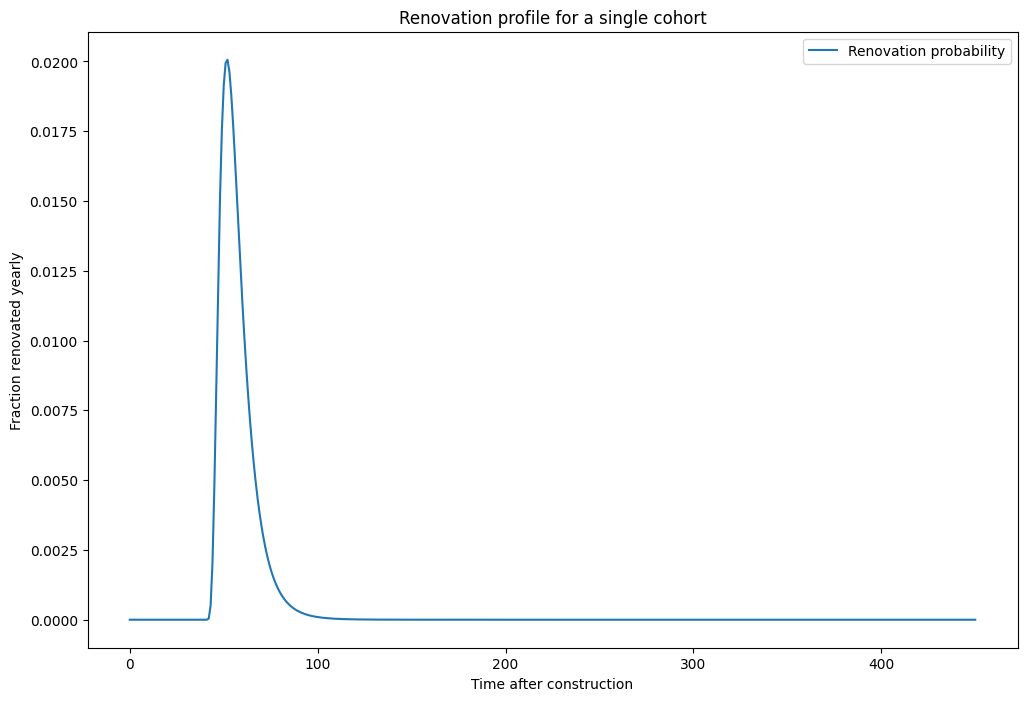

the actual mean of the outflow time in the first renovation cycles is at 19.0 years.


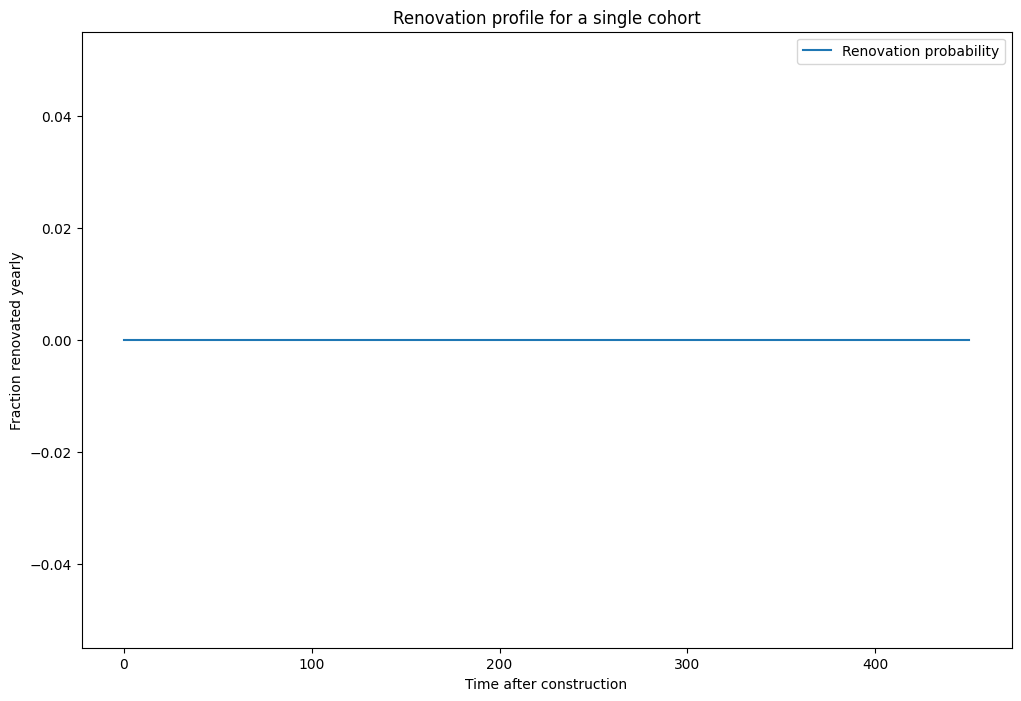

the actual mean of the outflow time in the first renovation cycles is at 0.0 years.


In [22]:
time_interval_pre_policy = [0, 450]
time_interval_post_policy = [0, 450]
\

no_cycles = 1
ren_mean_avg_pre_policy = 20
ren_mean_avg_post_policy = 20
ren_rel_std = 0.25

renovation_cycle_adv_pre_policy = get_renovation_cycles(
    1/3,time_interval_pre_policy, no_cycles, 
    ren_mean_cycle=ren_mean_avg_pre_policy, 
    ren_rel_deviation = ren_rel_std, loc=30, 
    distribution='lognorm', show = True)
renovation_cycle_adv_post_policy = get_renovation_cycles(
    2/3,time_interval_post_policy, no_cycles, 
    ren_mean_cycle=ren_mean_avg_post_policy, 
    ren_rel_deviation = ren_rel_std, loc=446, 
    distribution='lognorm', show = True)

renovation_cycle_adv_pre_policy = np.delete(
    renovation_cycle_adv_pre_policy, 
    [416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,
     432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,
     448,449,450])

renovation_cycle_avg_post_policy = np.delete(
    renovation_cycle_adv_pre_policy, 
    [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,
     25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,
     47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,
     69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,
     91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,
     110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,
     126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,
     142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,
     158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,
     174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,
     190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,
     206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,
     222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,
     238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,
     254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,
     270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,
     286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,
     302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,
     318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,
     334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,
     350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,
     366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,
     382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,
     398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,
     414,415])

renovation_cycle_adv = np.concatenate(
    (renovation_cycle_adv_pre_policy, 
     renovation_cycle_adv_post_policy), axis=0)

Renovation of SFH

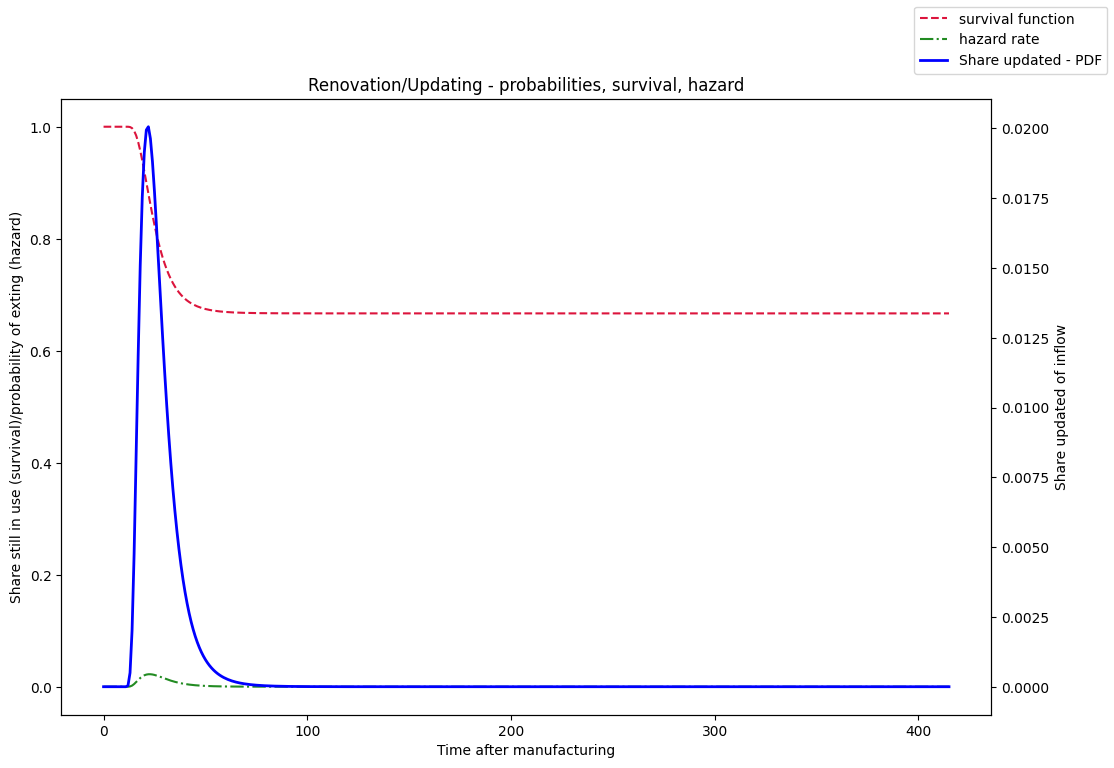

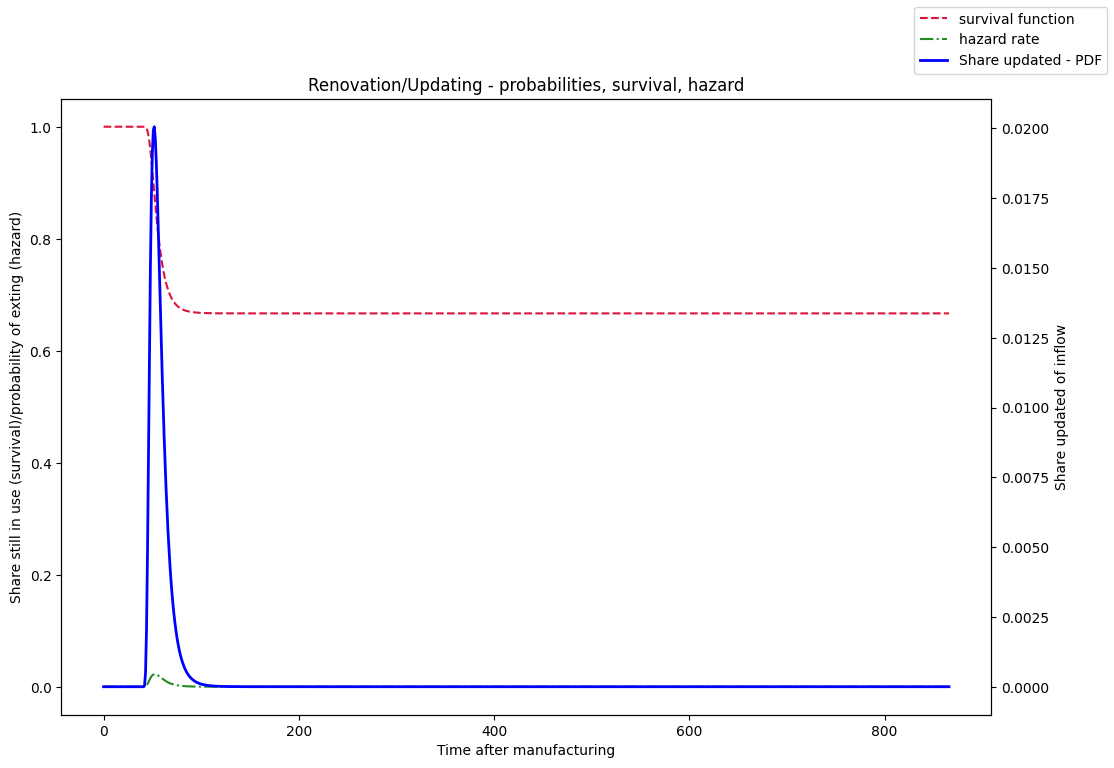

C:\Users\Solveig\Documents\GitHub\TEP4290_project\src/modules\renovation_state_modeling_scenario.py:381: UserWarning: Seems like your input stock contains non integers
  warnings.warn('Seems like your input stock contains non integers')


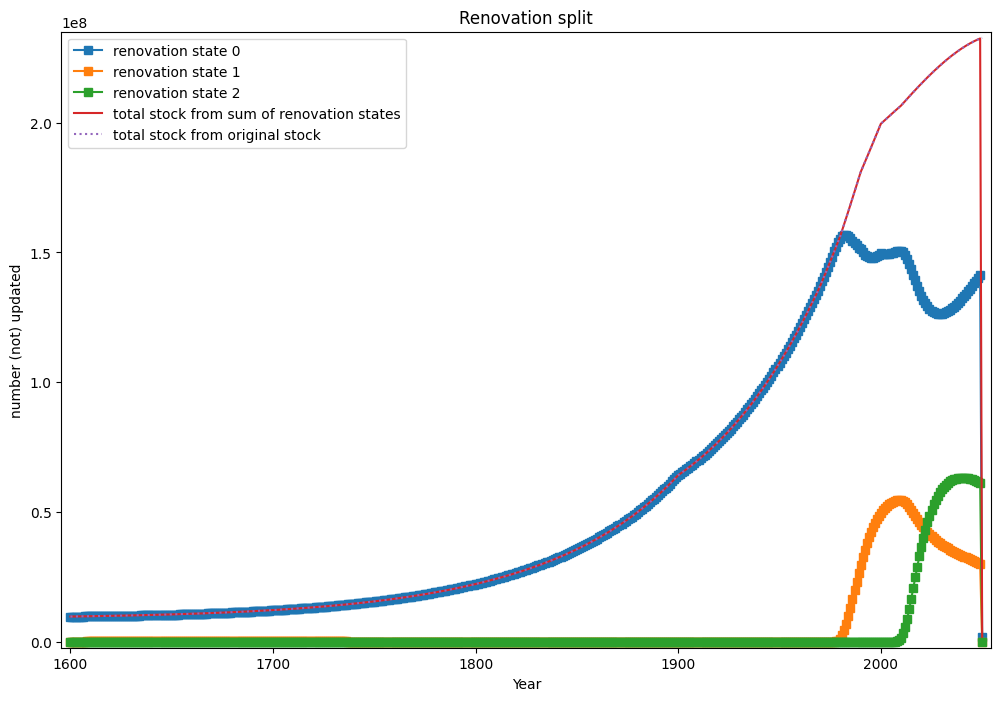

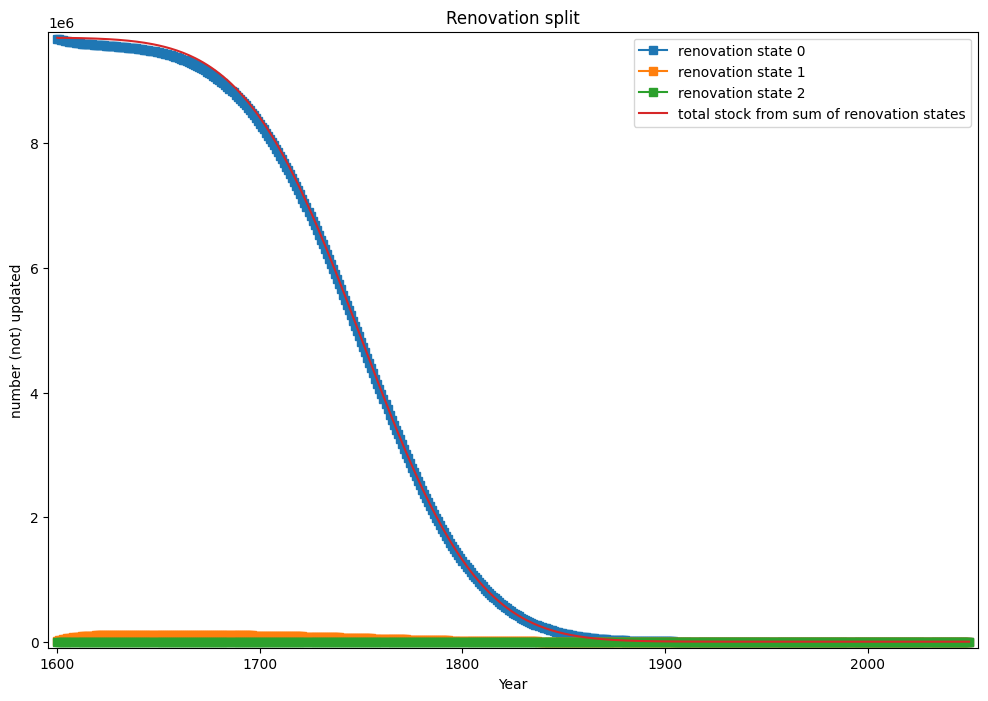

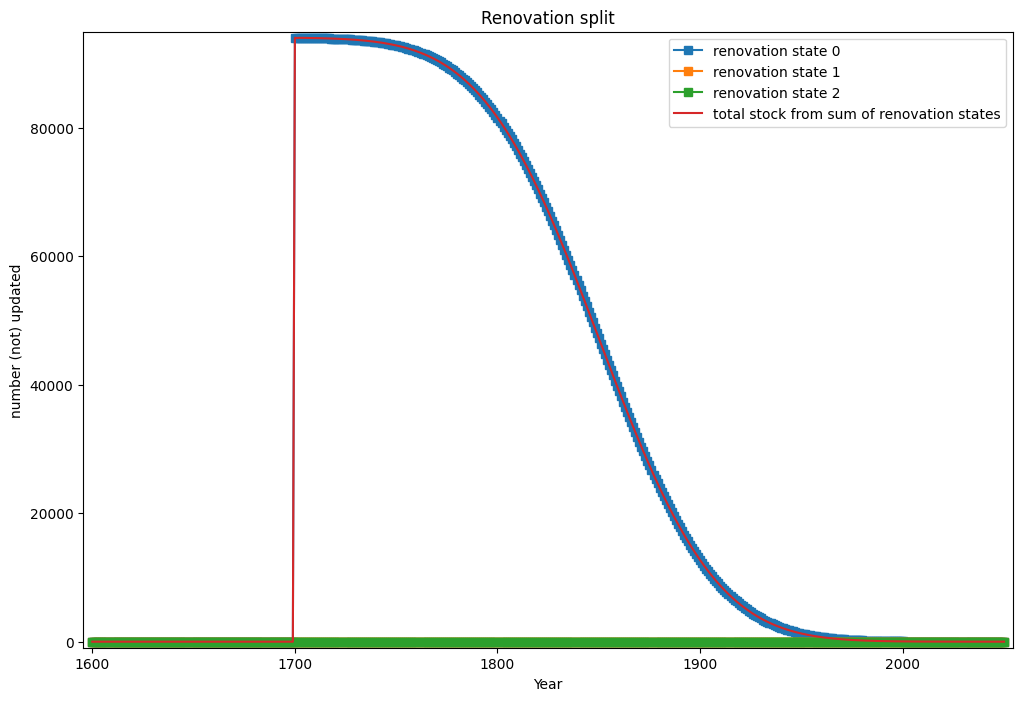

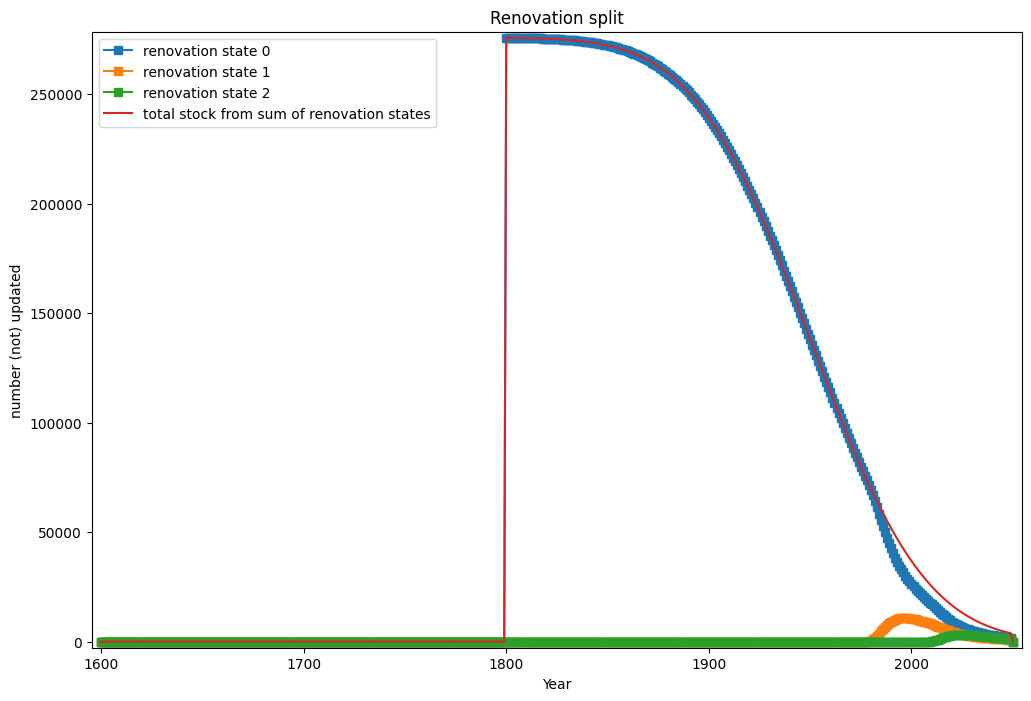

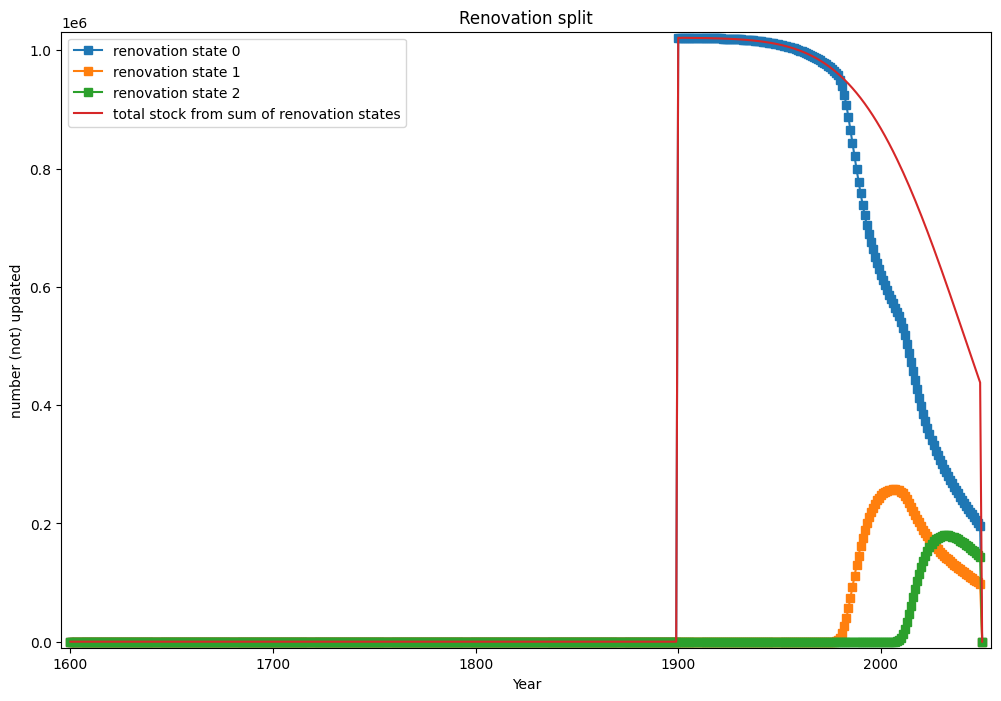

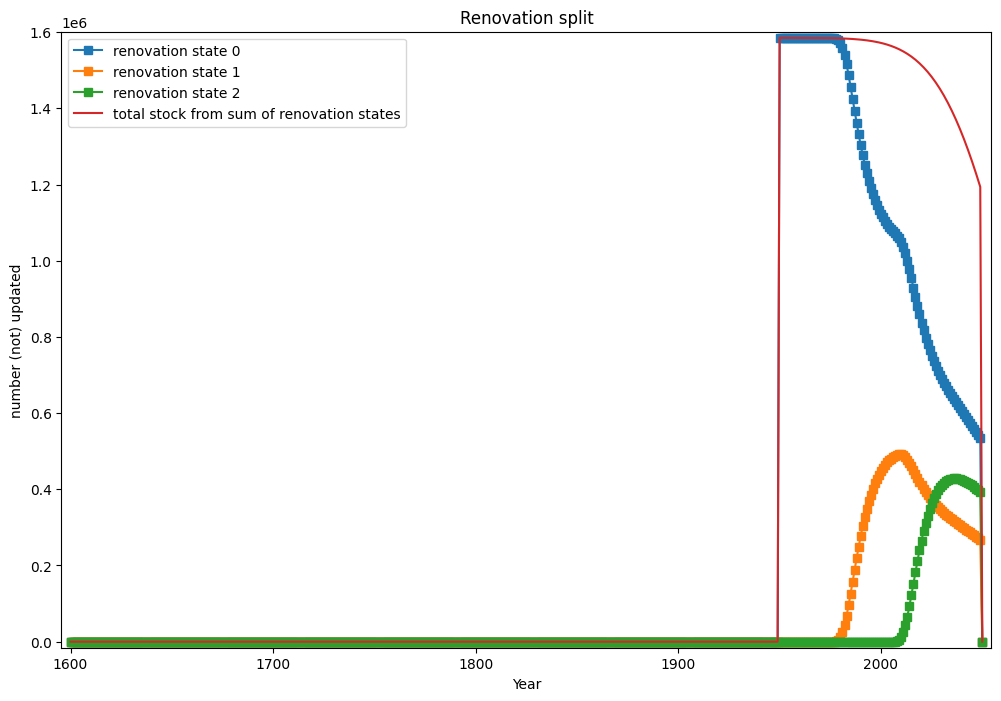

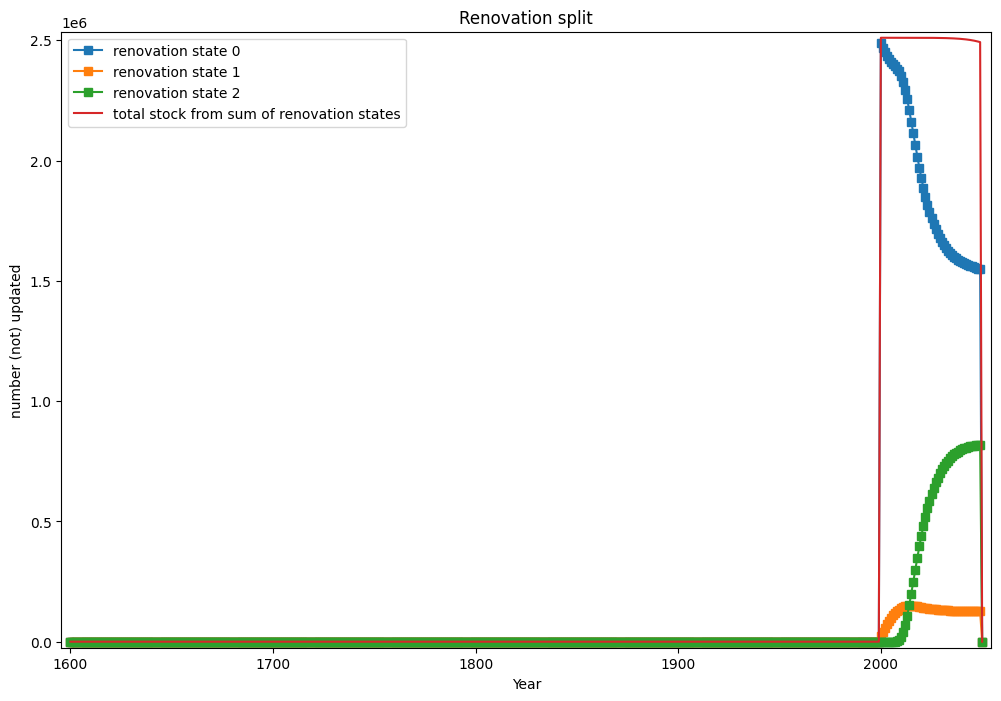

In [23]:
# SFH
ren_stock_model_SFH = RenovationStock(
    np.array(s_UFA_c_SFH), np.array(o_SFH_UFA), 
    [renovation_cycle_avg, renovation_cycle_adv], 
    np.array(s_UFA_c_SFH_df.index))
ren_stock_model_SFH.renovate()
ren_stock_model_SFH.plot_renovation_total_stock()
ren_stock_model_SFH.plot_renovation_states_cohort(
    [0,100,200,300,350,400])
stock_tcr_SFH = ren_stock_model_SFH.s_tc_p_r

Renovation of TH

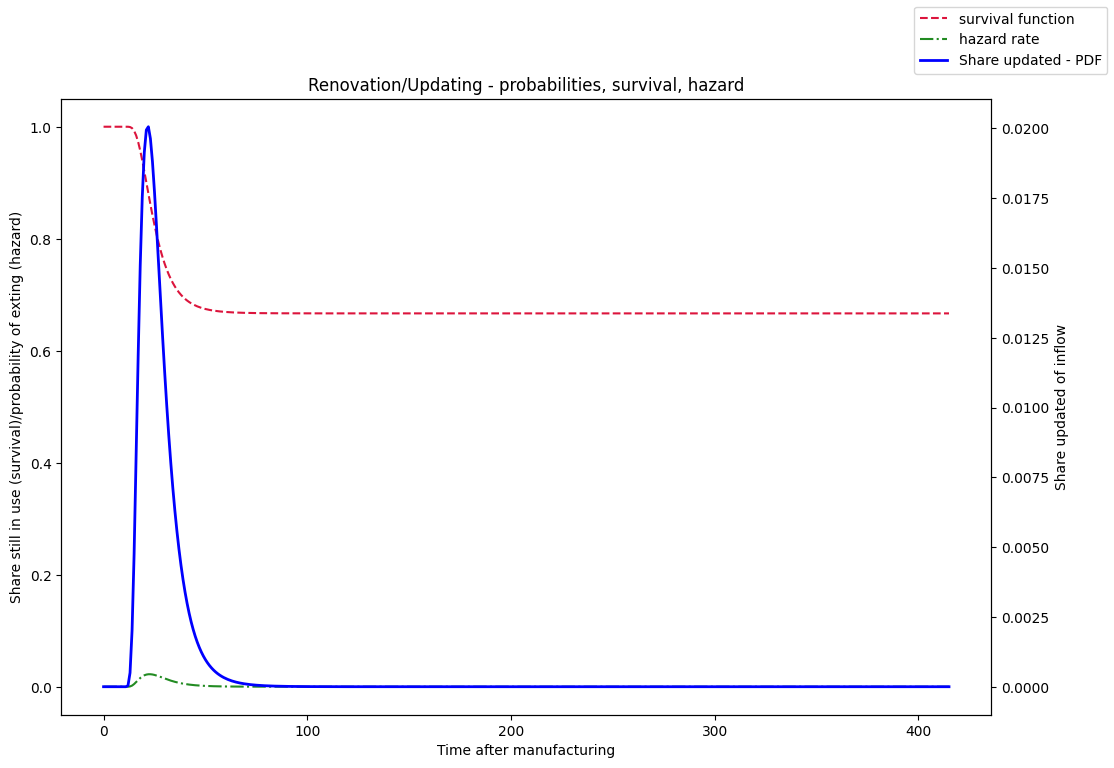

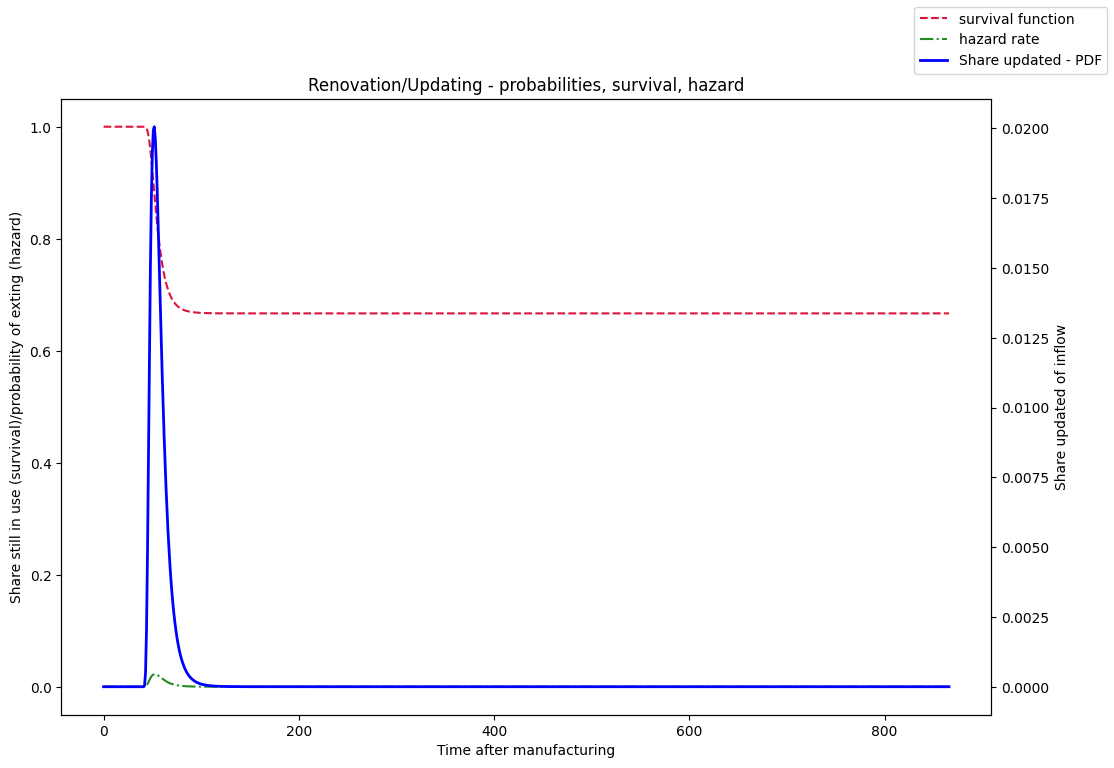

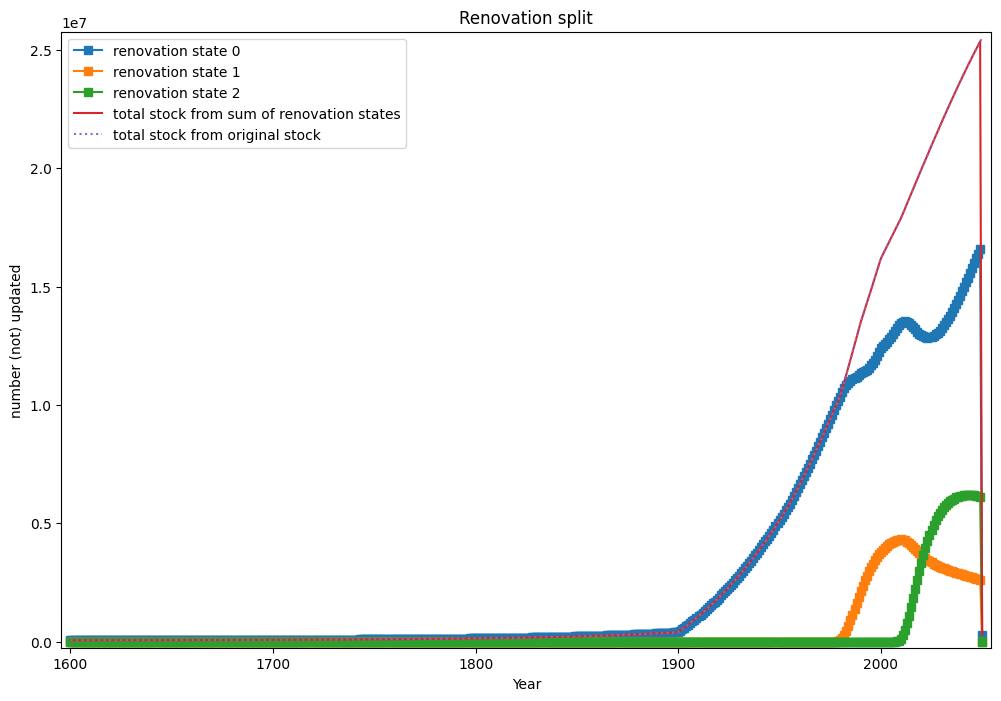

In [24]:
#TH
ren_stock_model_TH = RenovationStock(
    np.array(s_UFA_c_TH), np.array(o_TH_UFA), 
    [renovation_cycle_avg, renovation_cycle_adv], s_UFA_c_SFH_df.index)
ren_stock_model_TH.renovate()
ren_stock_model_TH.plot_renovation_total_stock()
stock_tcr_TH = ren_stock_model_TH.s_tc_p_r

Renovation AB

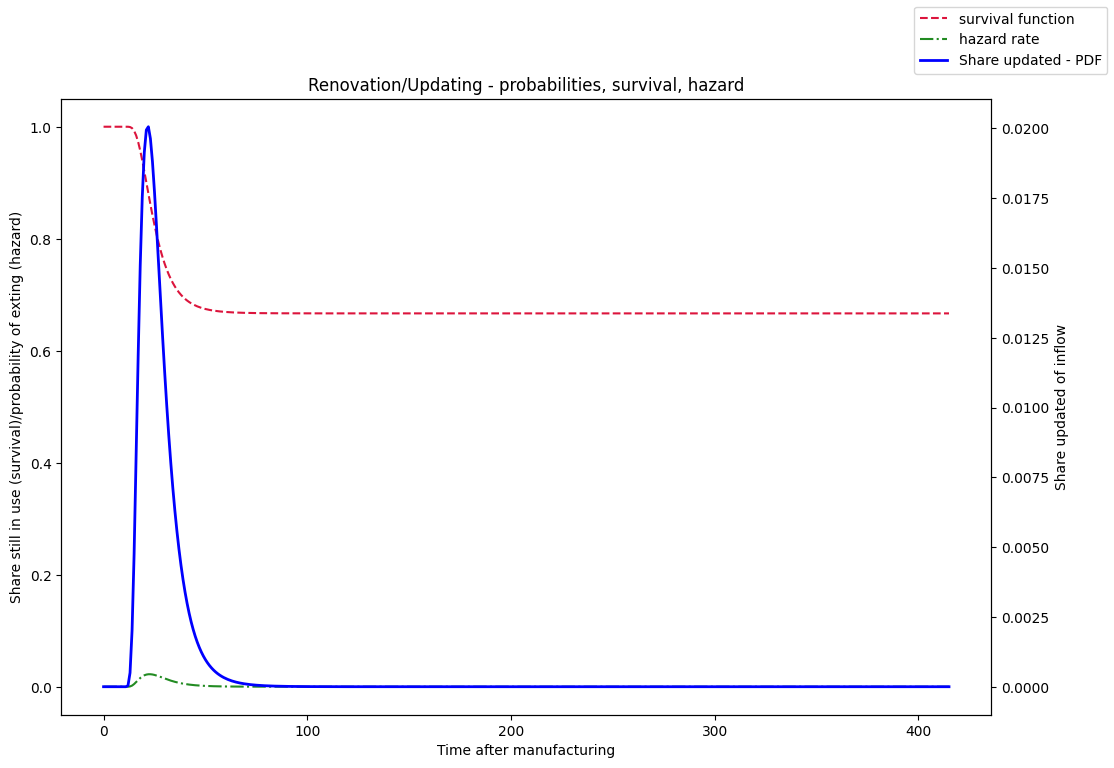

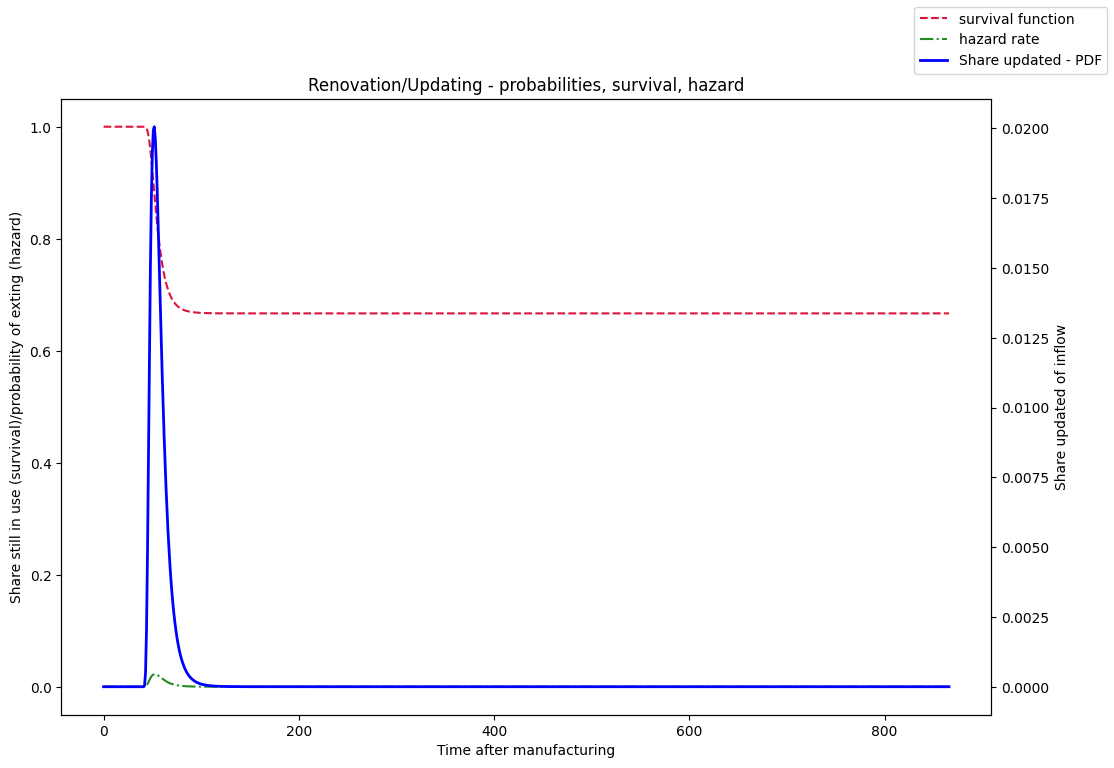

C:\Users\Solveig\Documents\GitHub\TEP4290_project\src/modules\renovation_state_modeling_scenario.py:386: RuntimeWarning: invalid value encountered in double_scalars
  if difference_ren_orig/np.sum(time_slice) > 0.05:


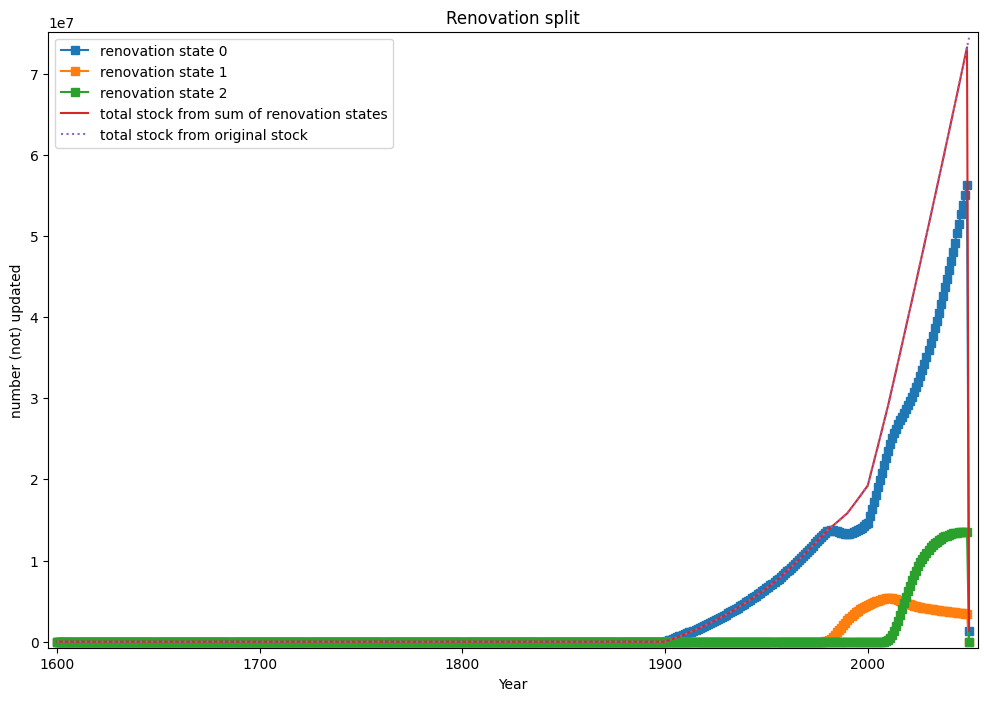

In [25]:
#AB
ren_stock_model_AB = RenovationStock(
    np.array(s_UFA_c_AB), np.array(o_AB_UFA), 
    [renovation_cycle_avg, renovation_cycle_adv], s_UFA_c_SFH_df.index)
ren_stock_model_AB.renovate()
ren_stock_model_AB.plot_renovation_total_stock()
stock_tcr_AB = ren_stock_model_AB.s_tc_p_r

Extend energy intensity to time dimension

Renovation of SFH by cohort

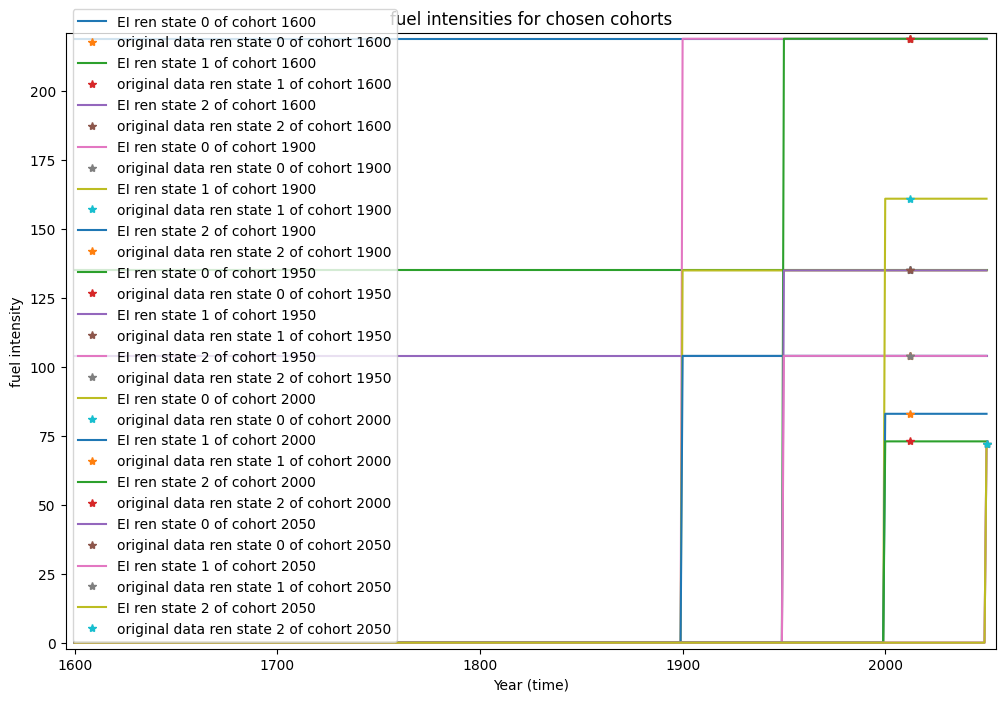

In [26]:
# No, average and advanced renovation
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1] 

# Add energy intensity
SFH_EI = EnergyIntensity(
    np.array(EI_SFH), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren, avg_ren, adv_ren])
EI_tcr_SFH = SFH_EI.EI_tc_p_r

SFH_EI.plot_some_EIs([0,300,350,400,450])

Renovation of TH by cohort

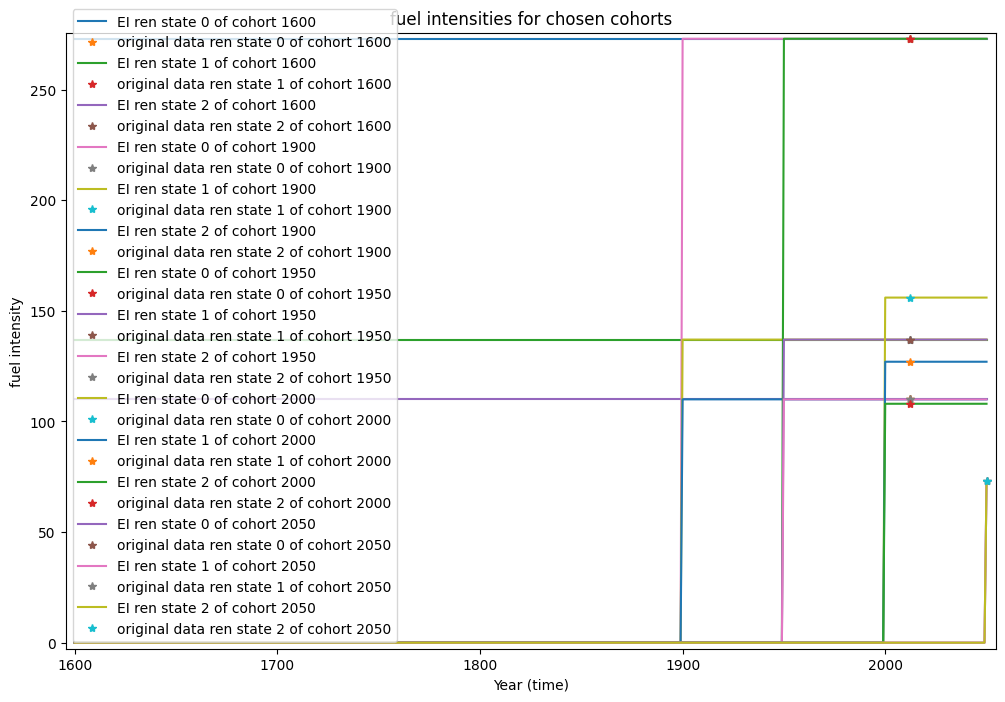

In [27]:
# No, average and advanced renovation
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1] 

#Add energy intensity
TH_EI = EnergyIntensity(
    np.array(EI_TH), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren, avg_ren, adv_ren])
EI_tcr_TH = TH_EI.EI_tc_p_r

TH_EI.plot_some_EIs([0,300,350,400,450])

Renovation of AB by cohort

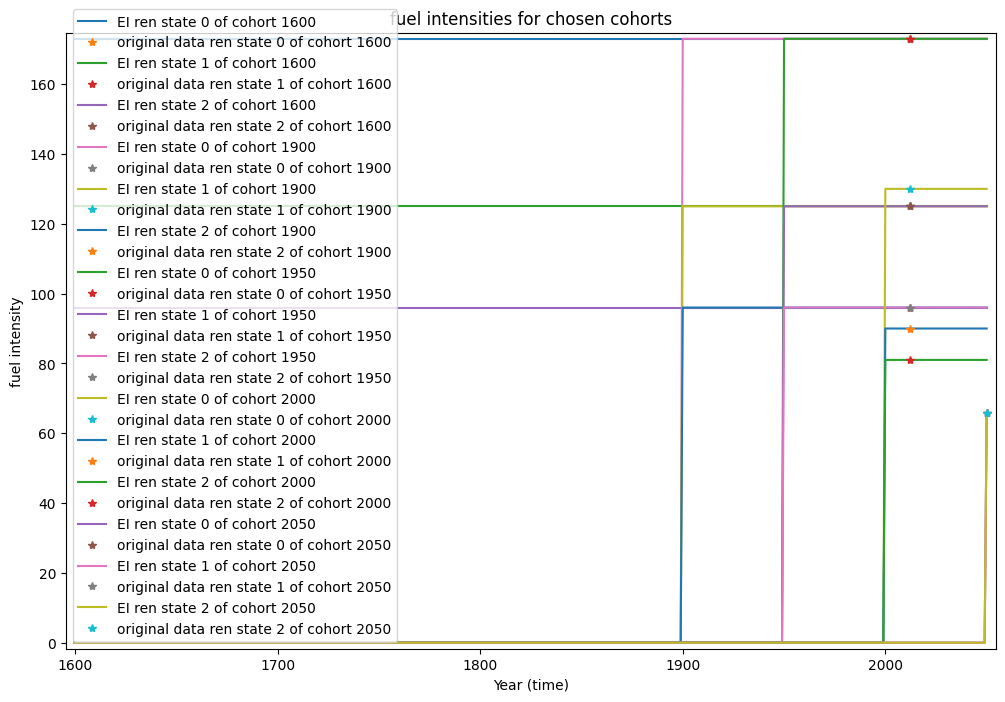

In [28]:
# No, average and advanced renovation
no_ren = [1, 1]
avg_ren = [1, 1] 
adv_ren = [1, 1] 

#Add energy intensity
AB_EI = EnergyIntensity(
    np.array(EI_AB), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren, avg_ren, adv_ren])
EI_tcr_AB = AB_EI.EI_tc_p_r

AB_EI.plot_some_EIs([0,300,350,400,450])

Calculate energy use for SFH

Text(0.5, 0, 'Year')

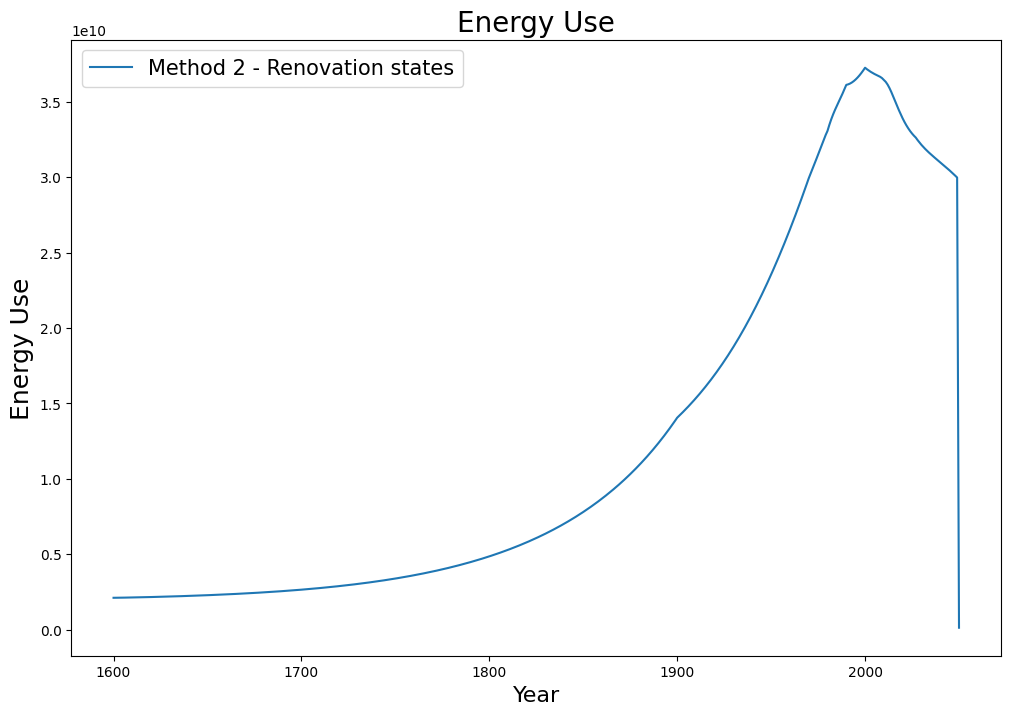

In [29]:
# Calculate energy consumption using the stock by type and cohorts
# Calculations done where t = time, c = cohort, and r = renovation states
energy_use_SFH = np.einsum('tcr, tcr->t', stock_tcr_SFH, EI_tcr_SFH)

# Compare values with previous calculations
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), energy_use_SFH, 
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Calculate energy use for TH

Text(0.5, 0, 'Year')

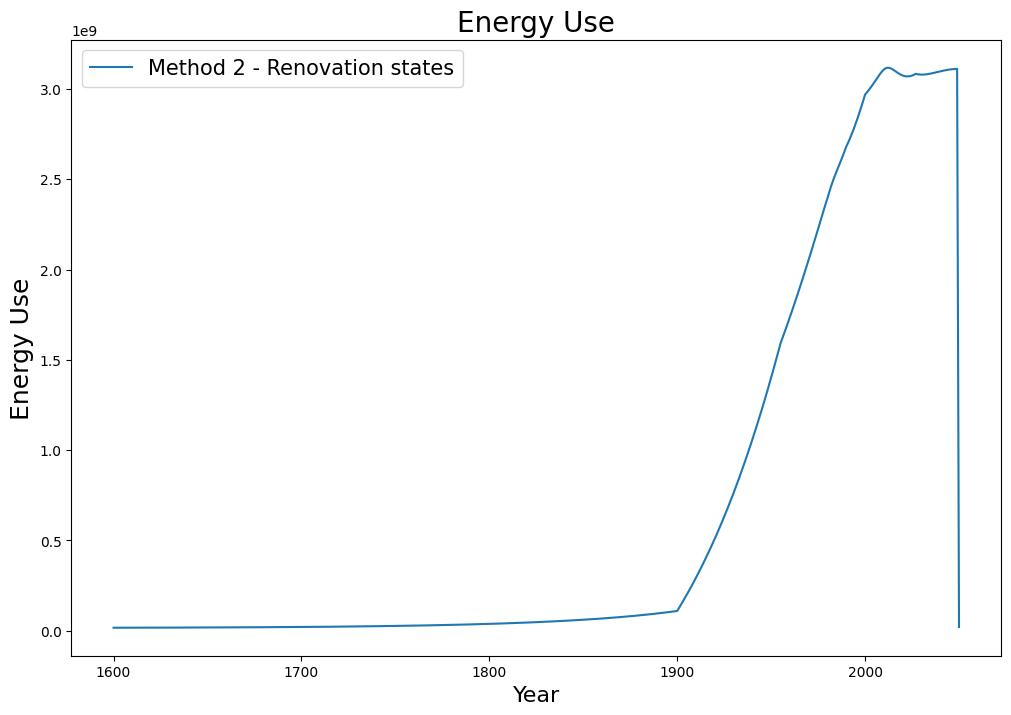

In [30]:
energy_use_TH = np.einsum('tcr, tcr->t', stock_tcr_TH, EI_tcr_TH)

# Compare values with previous calculations
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), energy_use_TH, 
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Calculate energy use for AB

Text(0.5, 0, 'Year')

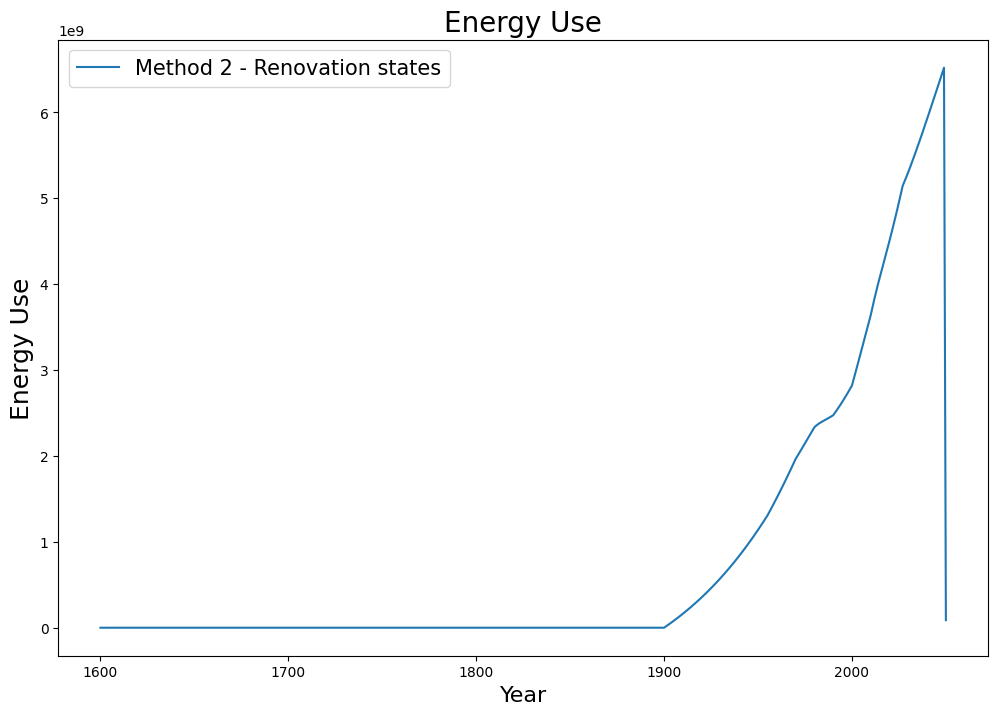

In [31]:
energy_use_AB = np.einsum('tcr, tcr->t', stock_tcr_AB, EI_tcr_AB)

# Compare values with previous calculations
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), energy_use_AB, 
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Sum for total energy use

Text(0.5, 0, 'Year')

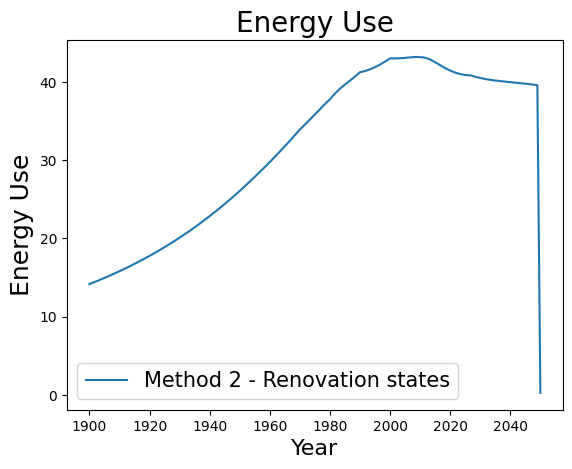

In [42]:
# Energy use for each type
energy_use_SFH_df = pd.DataFrame(energy_use_SFH)
energy_use_TH_df = pd.DataFrame(energy_use_TH)
energy_use_AB_df = pd.DataFrame(energy_use_AB)

# Total energy use
total_energy_use = (
    energy_use_SFH_df +
    energy_use_TH_df +
    energy_use_AB_df
)
total_energy_use

plt.plot(
    np.arange(1900,2051), total_energy_use[300:]/1000000000, 
    label='Method 2 - Renovation states')
plt.ylabel('Energy Use',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Energy Use', fontsize=20)
plt.xlabel('Year',fontsize =16)

Extend carbon intensity to time dimension for SFH

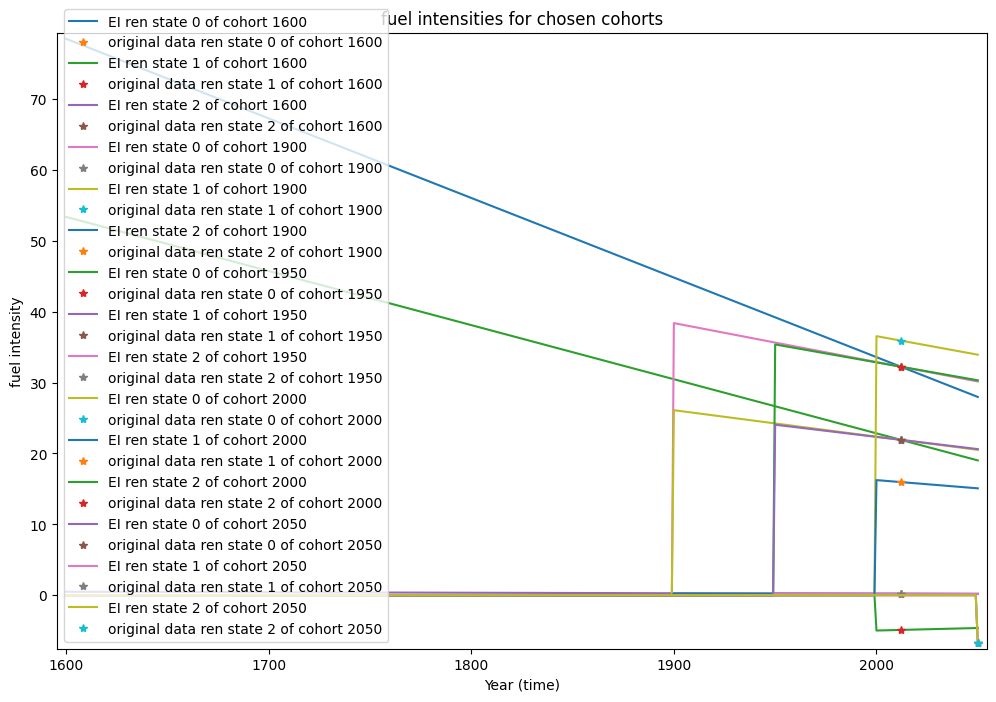

In [33]:
# No, average and advanced renovation
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change

#Add carbon intensity
SFH_CI = EnergyIntensity(
    np.array(CI_SFH), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])
CI_tcr_SFH = SFH_CI.EI_tc_p_r

SFH_CI.plot_some_EIs([0,300,350,400,450])

Extend carbon intensity to time dimension for TH

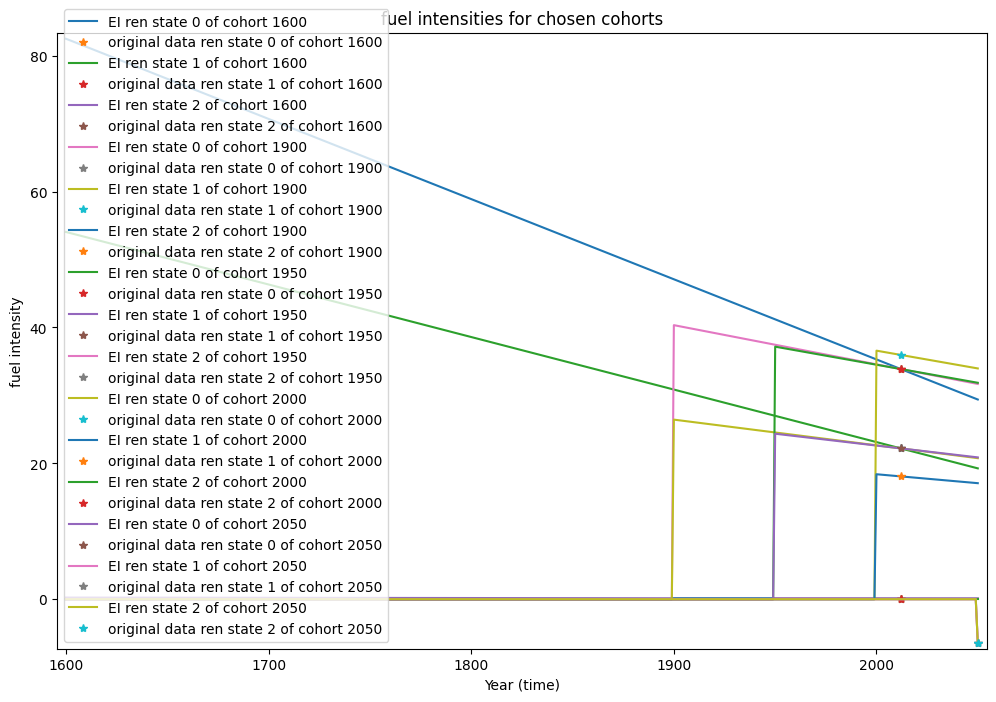

In [34]:
# No, average and advanced renovation
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change

#Add carbon intensity
TH_CI = EnergyIntensity(
    np.array(CI_TH), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])
CI_tcr_TH = TH_CI.EI_tc_p_r

TH_CI.plot_some_EIs([0,300,350,400,450])

Extend carbon intensity to time dimension for AB

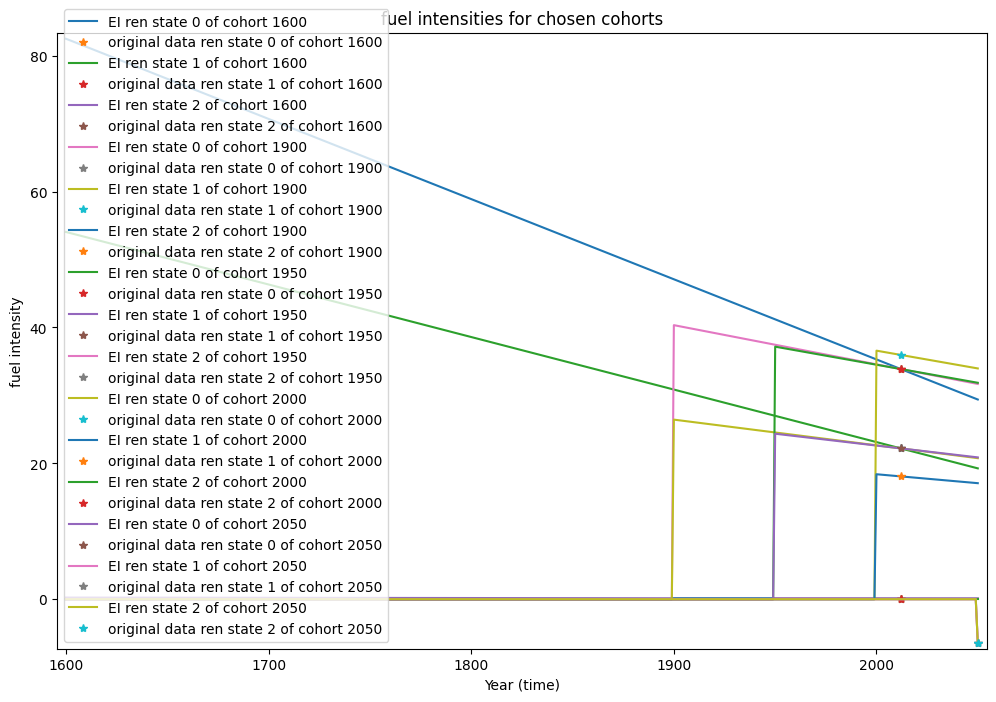

In [35]:
# No, average and advanced renovation
no_ren_c = [2.54, 0.905] # slope of change
avg_ren_c = [2.54, 0.905] # slope of change
adv_ren_c = [2.54, 0.905] # slope of change

#Add carbon intensity
AB_CI = EnergyIntensity(
    np.array(CI_TH), 2012, np.array(s_UFA_c_SFH_df.index), 
    adjustment_parameters=[no_ren_c, avg_ren_c, adv_ren_c])
CI_tcr_AB = AB_CI.EI_tc_p_r

AB_CI.plot_some_EIs([0,300,350,400,450])

Carbon emissions for SFH

Text(0.5, 0, 'Year')

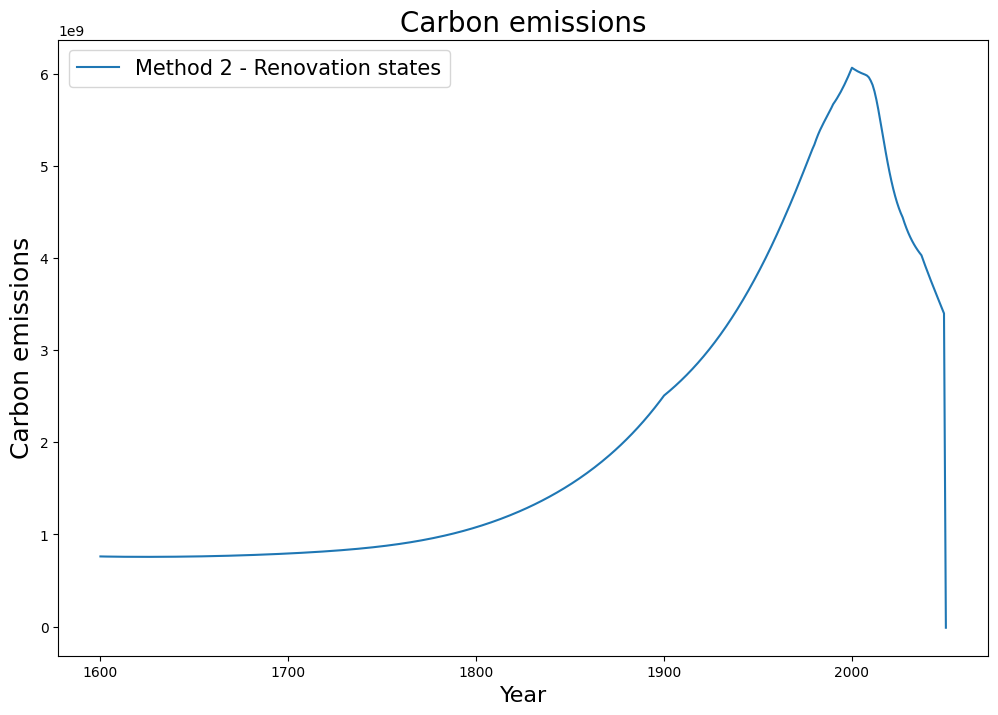

In [36]:
# Calculate emissions using the stock by cohorts
# Calculations done where t = time, c = cohort, and r = renovation states
carbon_emissions_SFH = np.einsum(
    'tcr, tcr->t', stock_tcr_SFH, CI_tcr_SFH)

# Compare values with previous calculations
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), carbon_emissions_SFH, 
    label='Method 2 - Renovation states')
plt.ylabel('Carbon emissions',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Carbon emissions', fontsize=20)
plt.xlabel('Year',fontsize =16)

Carbon emissions for TH

Text(0.5, 0, 'Year')

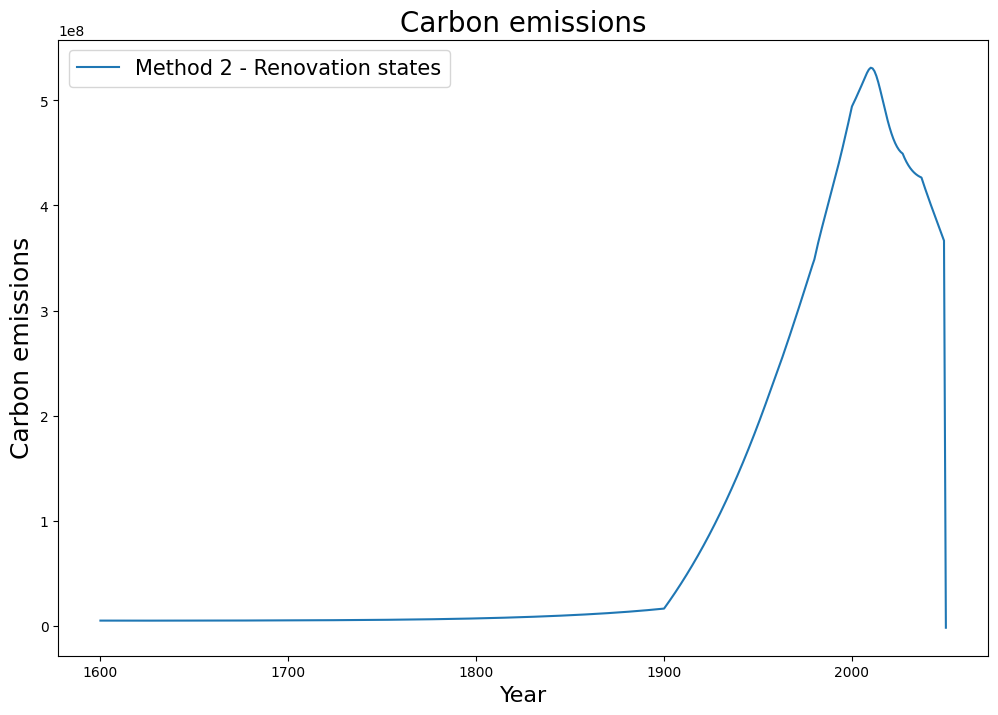

In [37]:
# Calculate emissions using the stock by cohorts
# Calculations done where t = time, c = cohort, and r = renovation states
carbon_emissions_TH = np.einsum('tcr, tcr->t', stock_tcr_TH, CI_tcr_TH)

# Compare values with previous calculations
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), carbon_emissions_TH, 
    label='Method 2 - Renovation states')
plt.ylabel('Carbon emissions',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Carbon emissions', fontsize=20)
plt.xlabel('Year',fontsize =16)

Carbon emissions for AB

Text(0.5, 0, 'Year')

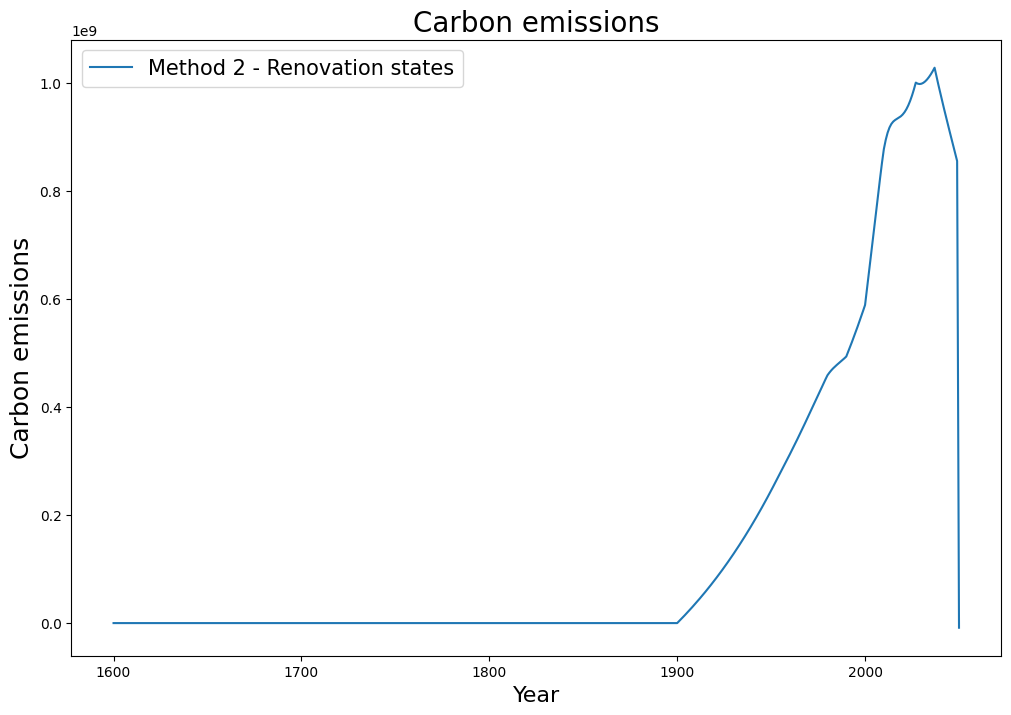

In [38]:
# Calculate emissions using the stock by cohorts
# Calculations done where t = time, c = cohort, and r = renovation states
carbon_emissions_AB = np.einsum('tcr, tcr->t', stock_tcr_AB, CI_tcr_AB)

# Compare values with previous calculations 
fig = plt.figure(figsize=(12,8))

plt.plot(
    np.arange(1600,2051), carbon_emissions_AB, 
    label='Method 2 - Renovation states')
plt.ylabel('Carbon emissions',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Carbon emissions', fontsize=20)
plt.xlabel('Year',fontsize =16)

Sum the totals of carbon use

Text(0.5, 0, 'Year')

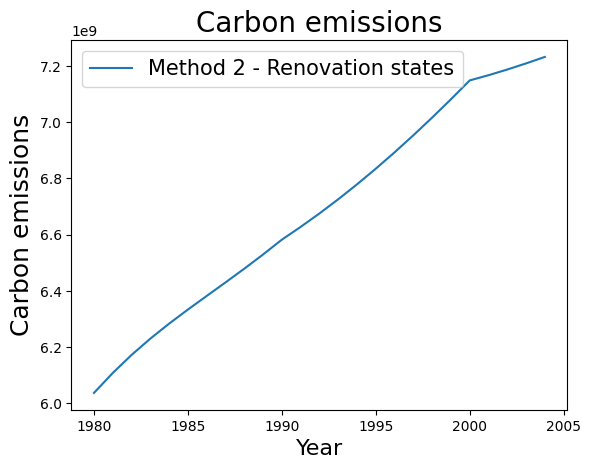

In [39]:
# currently in million metric ton
carbon_emissions_SFH_df = pd.DataFrame(carbon_emissions_SFH)
carbon_emissions_TH_df = pd.DataFrame(carbon_emissions_TH)
carbon_emissions_AB_df = pd.DataFrame(carbon_emissions_AB)

# Sum emissions by type to get the total emissions
total_carbon_emissions = (
    carbon_emissions_SFH_df
    + carbon_emissions_TH_df
    + carbon_emissions_AB_df
)
total_carbon_emissions

plt.plot(
    np.arange(1980,2005), total_carbon_emissions[380:405], 
    label='Method 2 - Renovation states')
plt.ylabel('Carbon emissions',fontsize =18)
plt.legend( loc='best',prop={'size':15})
plt.title('Carbon emissions', fontsize=20)
plt.xlabel('Year',fontsize =16)

Export plots of stock by renovation category and type

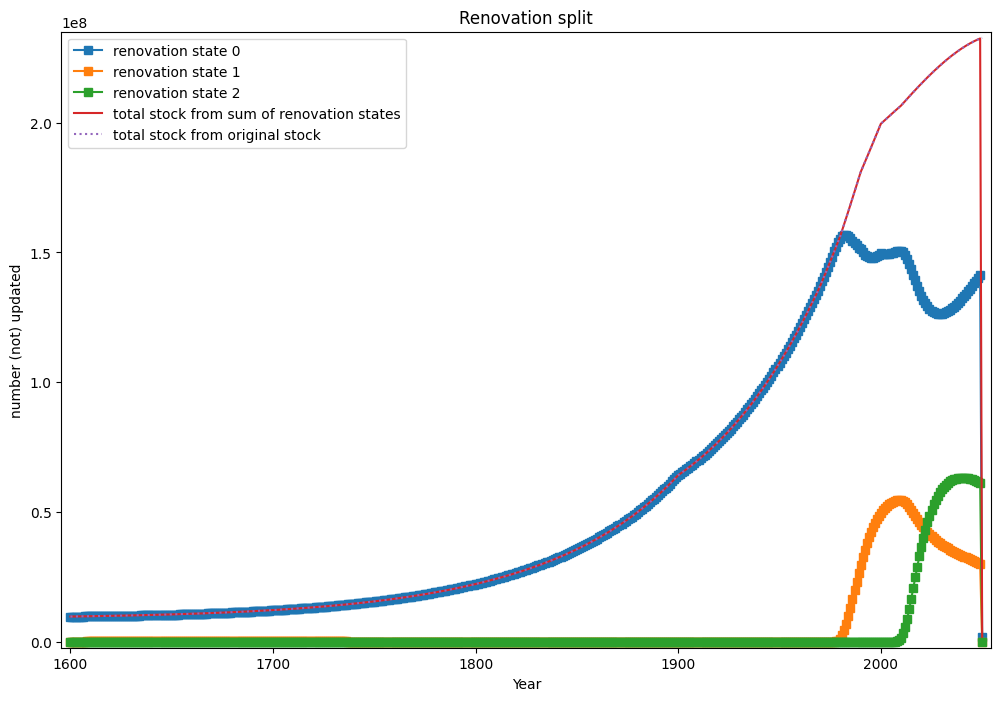

In [40]:
ren_stock_model_SFH.plot_renovation_total_stock()

Export model outputs

In [41]:
total_energy_use.to_excel(directory_path / 
                 'data/model_outputs_scenario_2/total_energy_use.xlsx')
total_carbon_emissions.to_excel(directory_path / 
                 'data/model_outputs_scenario_2/carbon_emissions_TEK_ren_intensities_and_share.xlsx')